In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [ ]:
df = pd.read_csv('/content/11. Number of domestic air travel passengers.csv', parse_dates=True, index_col='Date')

df.head()

,Number of domestic air passengers
Date,
2003-01-01,43032450
2003-02-01,41166780
2003-03-01,49992700
2003-04-01,47033260
2003-05-01,49152352


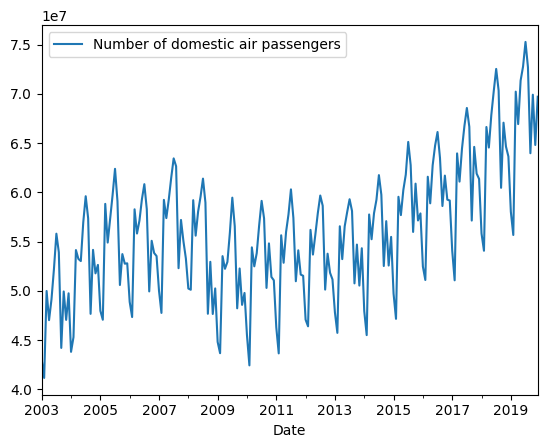

In [ ]:
df.plot()

plt.show()

Так как тренд явно неоднородный (то есть меняет свою траекторию на разных участках), то оставим только наиболее поздние записи с одинаковым трендом

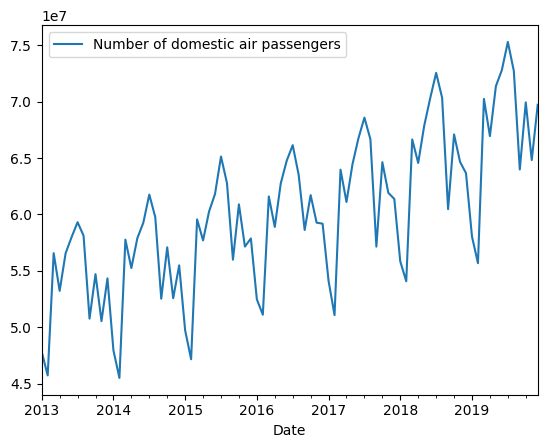

In [ ]:
df.loc[df.index.year >= 2013, :].plot()

plt.show()

In [ ]:
seasonality = 12 # Из предыдущих работ (сезонность аддитивная)

# Первичная модель (без дополнительных признаков)

In [ ]:
df_copy = df.loc[df.index.year >= 2013, :].copy(deep=True)

По графику выше видно, что тренд в целом неплохо описывается обыкновенной линейной моделями; попробуем его таким образом и представить

In [ ]:
df_copy['n'] = np.arange(1,df_copy.shape[0]+1,1)

df_copy.head()

,Number of domestic air passengers,n
Date,,
2013-01-01,47816859,1
2013-02-01,45740158,2
2013-03-01,56564538,3
2013-04-01,53228575,4
2013-05-01,56562929,5


## One-Hot encoding

Сперва попробуем закодировать сезонность при помощи унитарного кода

In [ ]:
df_copy_1 = df_copy.copy(deep=True)
df_copy_1['month_num'] = df_copy_1.index.month.values

y = df_copy_1['Number of domestic air passengers']
X = df_copy_1.drop(columns=['Number of domestic air passengers'])

In [ ]:
# Общий трансформер и пайплайн для ситуаций, где будет требоваться кодировать OneHotом
col_transf_ohe = ColumnTransformer(
    [('ohe', OneHotEncoder(), ['month_num'])],
    remainder='passthrough'
)

pipeline_ohe = Pipeline(
    [('transformation', col_transf_ohe),
     ('model', LinearRegression())]
)

In [ ]:
# Проведем кросс-валидацию на трех фолдах
tss = TimeSeriesSplit(n_splits=3, test_size=12, gap=0)
scores = -cross_val_score(pipeline_ohe, X, y, scoring='neg_mean_absolute_percentage_error', cv=tss, error_score='raise')

In [ ]:
scores.mean()

0.01757959408617346

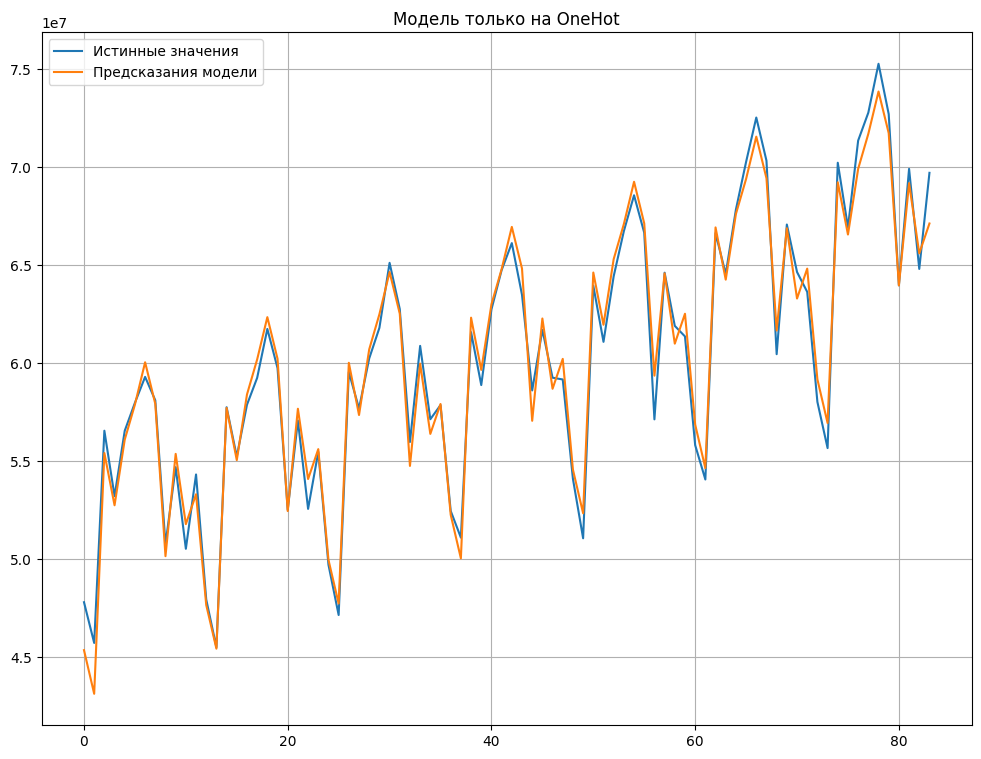

In [ ]:
# Отобразим получившуюся аппроксимацию
pipeline_ohe.fit(X, y)

plt.figure(figsize=(12,9))
plt.title('Модель только на OneHot')
plt.plot(df_copy["Number of domestic air passengers"].values, label='Истинные значения')
plt.plot(pipeline_ohe.predict(X), label='Предсказания модели')
plt.legend()
plt.grid()

plt.show()

## Описание сезонности через суммы Фурье

Попробуем подобрать оптимальное число компонент ряда Фурье для описания сезонности

In [ ]:
df_copy_2 = df_copy.copy(deep=True)

In [ ]:
simple_regr = LinearRegression() # В местах, где не надо будет использовать OneHot можно ограничиться простой регрессией

In [ ]:
best_score = np.inf
best_n = 0

# Найдем наилучшее число компонент по результатам той же кросс-валидации
for n in range(1, 30):
  df_copy_2[f'cos_{n}'] = np.cos((df_copy_2['n']-1) * 2 * n * np.pi / seasonality)
  df_copy_2[f'sin_{n}'] = np.sin((df_copy_2['n']-1) * 2 * n * np.pi / seasonality)

  y = df_copy_2['Number of domestic air passengers']
  X = df_copy_2.drop(columns=['Number of domestic air passengers'])

  val_score = -cross_val_score(simple_regr, X, y, scoring='neg_mean_absolute_percentage_error', cv=tss, error_score='raise').mean()

  if (val_score < best_score):
    best_n = n
    best_score = val_score

In [ ]:
best_n, best_score

(5, 0.01755855936888552)

Описание сезонности через первые 5 компонент ряда Фурье оказалось оптимальным и показало результат немного лучше предыдущего способа описания сезонности (хотя разница скорее всего не стат. значима), поэтому будем использовать ее далее в качестве базовой модели

In [ ]:
for n in range(1, best_n + 1):
  df_copy[f'cos_{n}'] = np.cos((df_copy['n']-1) * 2 * n * np.pi / seasonality)
  df_copy[f'sin_{n}'] = np.sin((df_copy['n']-1) * 2 * n * np.pi / seasonality)

y = df_copy['Number of domestic air passengers']
X = df_copy.drop(columns=['Number of domestic air passengers'])

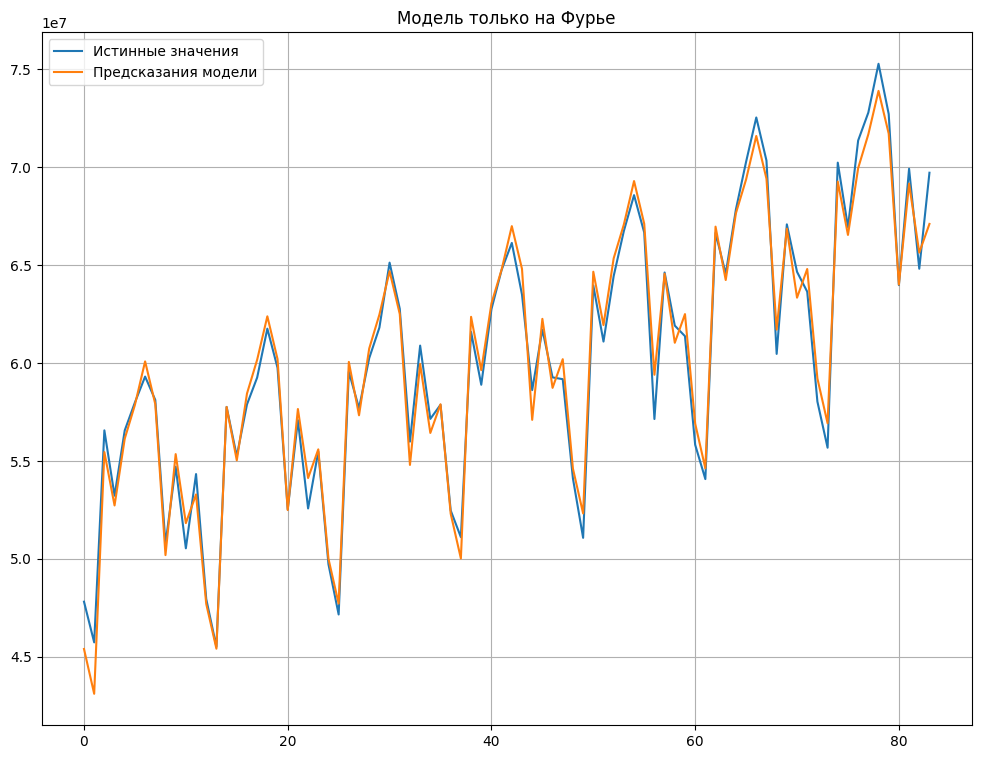

In [ ]:
# Отрисуем полученную аппроксимацию
simple_regr.fit(X, y)

plt.figure(figsize=(12,9))
plt.title('Модель только на Фурье')
plt.plot(df_copy["Number of domestic air passengers"].values, label='Истинные значения')
plt.plot(simple_regr.predict(X), label='Предсказания модели')
plt.legend()
plt.grid()

plt.show()

# Добавление новых признаков

Попробуем добавить новых признаков в базовую модель:

  1. Годовой лаг на целевую переменную
  2. Номер месяца (и закодировать его через OneHot, по сути объединив две модели)

In [ ]:
# Добавляем лаг (отбрасывать ничего не придется так как мы строим модель не по всем исходным данным)
df_copy['seas_lag'] = df_copy['Number of domestic air passengers'].shift(12)
df_copy.loc[:'2013-12-01',  'seas_lag'] = df.loc[df.index.year == 2012, 'Number of domestic air passengers'].values

# Добавляем номер месяца для OneHot
df_copy['month_num'] = df_copy.index.month.values


y = df_copy.loc[:,'Number of domestic air passengers']
X = df_copy.drop(columns=['Number of domestic air passengers'])

Сперва попробуем посмотреть на результаты добавления признаков по отдельности, а потом вместе

In [ ]:
# Без OneHot, вместе с лагом
-cross_val_score(simple_regr, X.drop(columns=['month_num']), y, scoring='neg_mean_absolute_percentage_error', cv=tss, error_score='raise').mean()

0.015609224015324136

In [ ]:
# Вместе с OneHot, без лага
-cross_val_score(pipeline_ohe, X.drop(columns=['seas_lag']), y, scoring='neg_mean_absolute_percentage_error', cv=tss, error_score='raise').mean()

0.017579594067506383

In [ ]:
# Вместе с OneHot и лагом
-cross_val_score(pipeline_ohe, X, y, scoring='neg_mean_absolute_percentage_error', cv=tss, error_score='raise').mean()

0.01567687980118389

Результат при добавлении только лага оказался наилучшим, так что откинем столбец с номером месяца (не будем пытаться смешивать унитарное кодирование и частичные суммы Фурье)

In [ ]:
df_copy.drop(columns=['month_num'], inplace=True)
X.drop(columns=['month_num'], inplace=True)
simple_regr.fit(X,y)

# Построение прогноза на три года

Напишем функцию для генерации новых данных для прогноза

In [ ]:
def gen_new_data(n_pred, lag, ind):
  res = {}

  res['Number of domestic air passengers'] = -1
  res['n'] = [n_pred + df_copy.iloc[-1]['n'] + 1]

  for i in range(1, best_n + 1):
    res[f'cos_{i}'] = [np.cos((res['n'][0]-1) * 2 * i * np.pi / seasonality)]
    res[f'sin_{i}'] = [np.sin((res['n'][0]-1) * 2 * i * np.pi / seasonality)]

  res['seas_lag'] = [lag]

  return pd.DataFrame(res, index=[ind])

Так как необходимо обеспечивать новые данные постоянным лагом, то будем генерировать данные пачками, соразмерно величине лага (просто для удобства); для лага первой пачки будем использовать истинные значения из исходного датафрейма, а для остальных будем брать предсказания

In [ ]:
df_for_pred = df_copy.iloc[-12:]
preds_df = pd.DataFrame(columns = df_for_pred.columns)

for year in range(3):
  for i in range(seasonality):
    if year == 0:
      preds_df = pd.concat([preds_df, gen_new_data(i, df_for_pred.iloc[i]['Number of domestic air passengers'], i)])
    else:
      preds_df = pd.concat([preds_df, gen_new_data(i + year * 12, preds_df.iloc[i + 12 * (year - 1)]['Number of domestic air passengers'], i + year * 12)])

  preds = simple_regr.predict(preds_df.drop(columns='Number of domestic air passengers').iloc[year * 12:])
  preds_df.loc[year * 12:, 'Number of domestic air passengers'] = preds

Соединим аппроксимацию и прогноз для отрисовки

In [ ]:
approx_and_pred = np.concatenate([simple_regr.predict(X), preds_df['Number of domestic air passengers'].values])

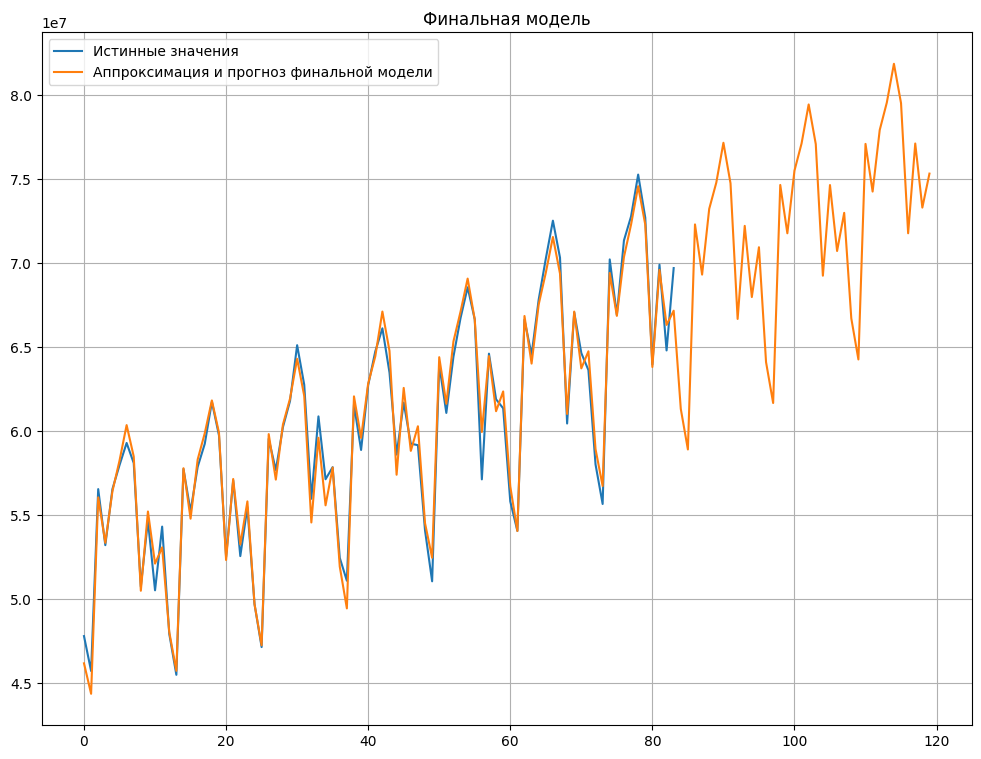

In [ ]:
# Отрисуем получившееся на графике
plt.figure(figsize=(12,9))
plt.title('Финальная модель')
plt.plot(df_copy["Number of domestic air passengers"].values, label='Истинные значения')
plt.plot(approx_and_pred, label='Аппроксимация и прогноз финальной модели')
plt.legend()
plt.grid()

plt.show()